In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime, timedelta

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1151 records for KRBN
X_train shape: (872, 60, 1), y_train shape: (872,)
X_test shape: (219, 60, 1), y_test shape: (219,)
Training LSTM model...
Epoch 1/30



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.1156 - val_loss: 0.0025
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0095 - val_loss: 0.0023
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0051 - val_l

/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))


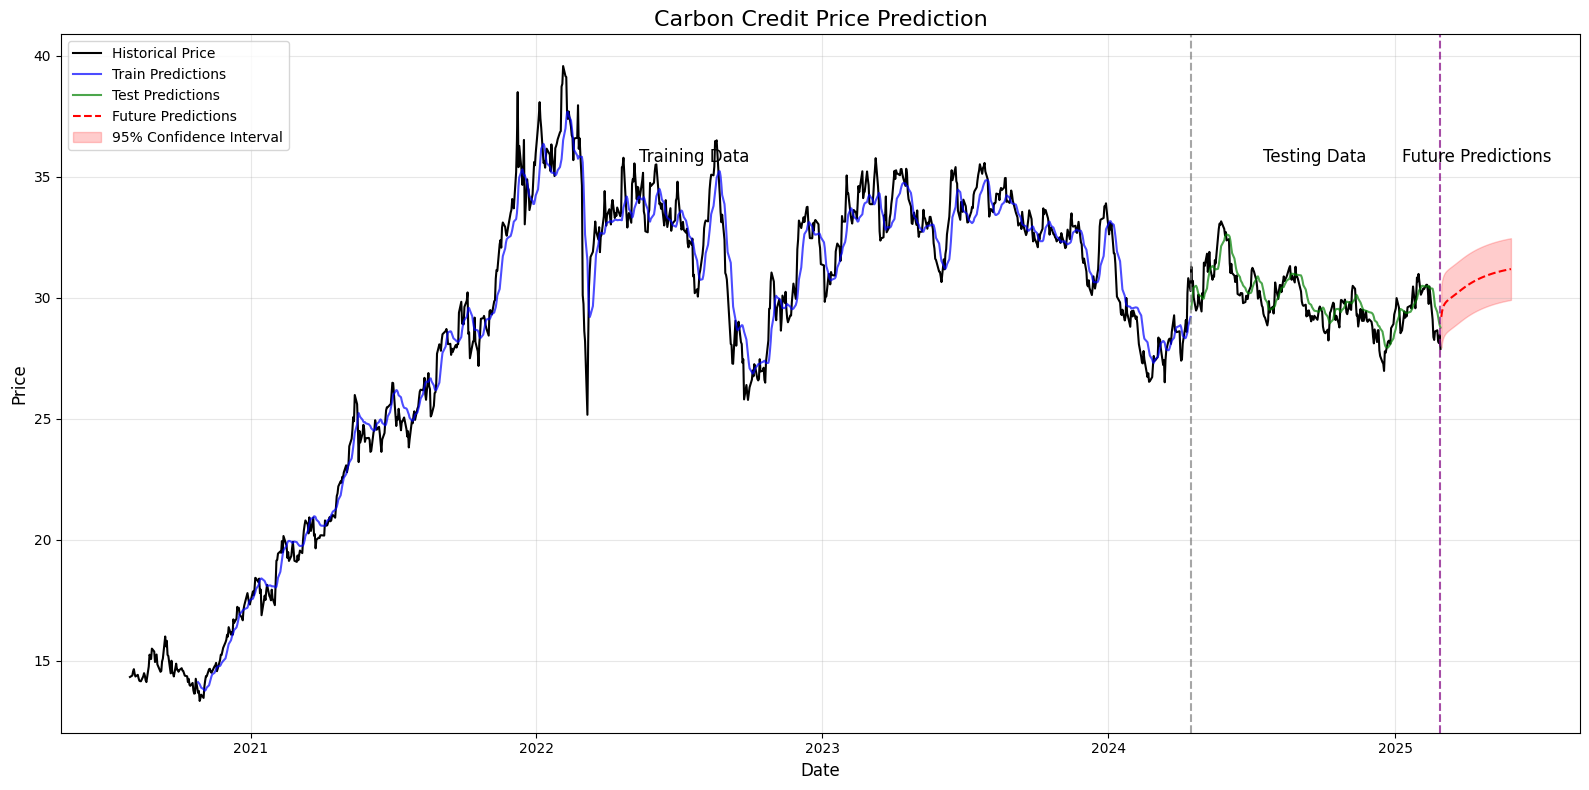

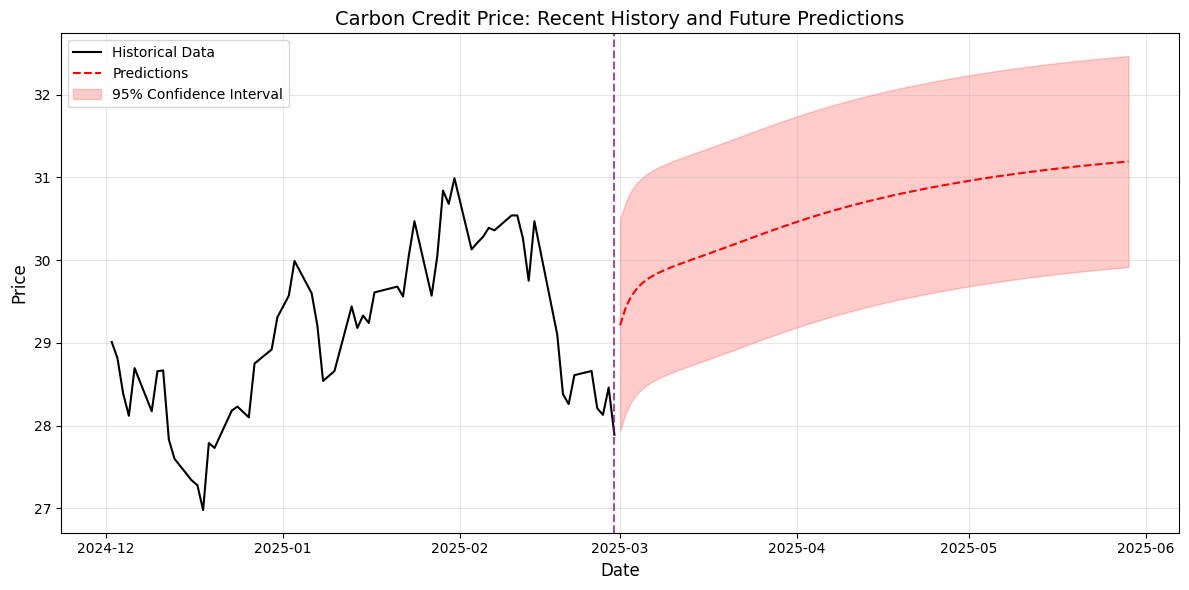

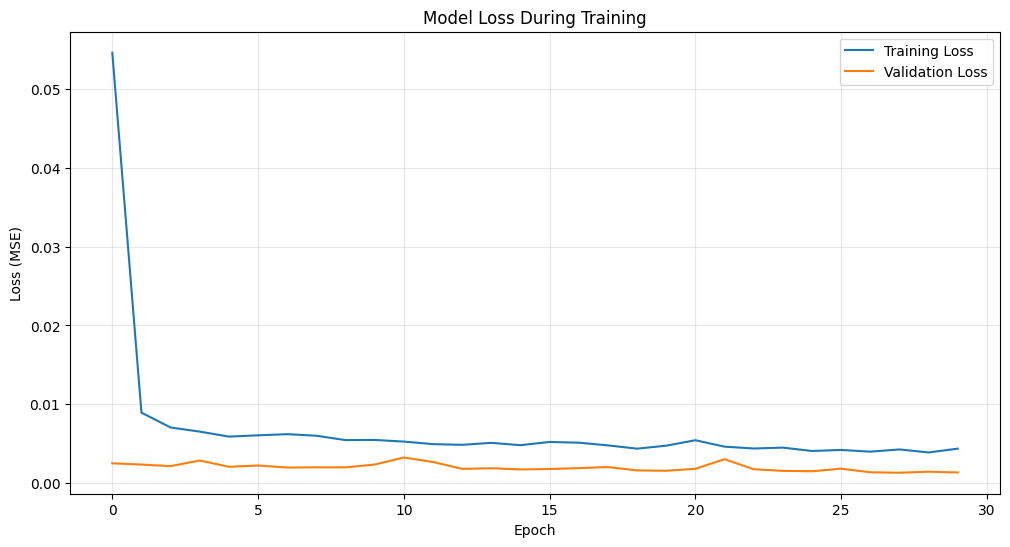

Could not create enhanced visualizations: only length-1 arrays can be converted to Python scalars

Prediction Summary:
Model train RMSE: 1.02
Model test RMSE: 0.65

Future Price Predictions (next 10 days):
            Predicted_Price
Date                       
2025-03-01        29.213495
2025-03-02        29.429369
2025-03-03        29.568184
2025-03-04        29.661924
2025-03-05        29.728962
2025-03-06        29.779861
2025-03-07        29.820822
2025-03-08        29.855532
2025-03-09        29.886248
2025-03-10        29.914402

Full predictions saved to 'carbon_price_predictions.csv'
Historical data saved to 'carbon_historical_data.csv'


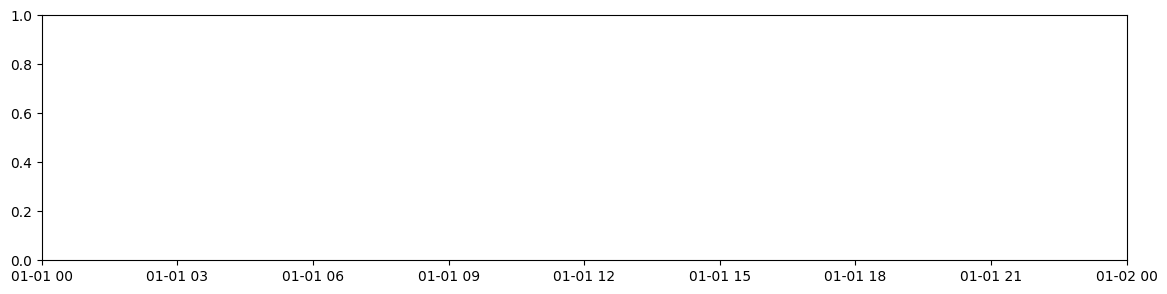

In [14]:


def fetch_carbon_data(ticker="KRX:5565", period="5y"):
    """
    Fetch carbon credit price data using yfinance.
    Common tickers:
    - KRX:5565 (Korea Exchange)
    - ECX.F (European Climate Exchange Future)
    - KRBN (KraneShares Global Carbon ETF)
    """
    try:
        data = yf.download(ticker, period=period)
        print(f"Successfully downloaded {len(data)} records for {ticker}")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return generate_sample_data()

def generate_sample_data(days=1000):
    """Generate sample carbon credit price data with realistic patterns."""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    base_price = np.linspace(20, 50, len(date_range))

    seasonality = 5 * np.sin(np.linspace(0, 2*np.pi * (len(date_range)/365), len(date_range)))

    noise = np.random.normal(0, 1, len(date_range))

    price = base_price + seasonality + noise.cumsum() * 0.1

    volume = np.abs(np.diff(np.concatenate([[price[0]], price]))) * 100000 + np.random.normal(500000, 100000, len(date_range))

    df = pd.DataFrame({
        'Open': price * 0.99,
        'High': price * 1.02,
        'Low': price * 0.98,
        'Close': price,
        'Adj Close': price,
        'Volume': volume.astype(int)
    }, index=date_range)

    print("Generated sample data for demonstration")
    return df

def preprocess_data(df, look_back=60, train_split=0.8, target_col='Close'):
    """Prepare data for LSTM model."""
    data = df[target_col].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - look_back):
        X.append(data_scaled[i:i+look_back, 0])
        y.append(data_scaled[i+look_back, 0])

    X, y = np.array(X), np.array(y)

    if len(X) == 0:
        print("Not enough data points for the given look_back period.")
        return None, None, None, None, scaler

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    train_size = int(len(X) * train_split)
    if train_size == 0:
        train_size = 1  # Ensure at least one sample for training

    X_train, X_test = X[:train_size], X[train_size:] if train_size < len(X) else (X, np.array([]))
    y_train, y_test = y[:train_size], y[train_size:] if train_size < len(y) else (y, np.array([]))

    return X_train, X_test, y_train, y_test, scaler

def build_lstm_model(look_back=60):
    """Create and compile LSTM model."""
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(X_train, y_train, epochs=100, batch_size=32, verbose=1):
    """Train the LSTM model."""
    model = build_lstm_model(look_back=X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=verbose
    )
    return model, history

def predict_future(model, last_sequence, scaler, n_future=30):
    """Predict future values based on the last known sequence."""
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_future):
        current_prediction = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)[0, 0]


        future_predictions.append(current_prediction)

        current_sequence = np.append(current_sequence[1:], current_prediction)

    future_predictions = scaler.inverse_transform(
        np.array(future_predictions).reshape(-1, 1)
    ).flatten()

    return future_predictions

def plot_predictions(df, train_pred, test_pred, future_pred, look_back, future_dates, y_train_actual, y_test_actual):
    """Create visualization of predictions vs actual values."""
    plt.figure(figsize=(16, 8))

    train_pred_index = df.index[look_back:look_back+len(train_pred)]
    test_pred_index = df.index[look_back+len(train_pred):look_back+len(train_pred)+len(test_pred)]

    plt.plot(df.index, df['Close'], label='Historical Price', color='black')

    plt.plot(train_pred_index, train_pred, label='Train Predictions', color='blue', alpha=0.7)
    if len(test_pred) > 0:
        plt.plot(test_pred_index, test_pred, label='Test Predictions', color='green', alpha=0.7)
        rmse = np.sqrt(np.mean(np.square(y_test_actual - test_pred)))
    else:
        rmse = np.sqrt(np.mean(np.square(y_train_actual - train_pred)))

    plt.plot(future_dates, future_pred, label='Future Predictions', color='red', linestyle='--')

    plt.fill_between(
        future_dates,
        future_pred - rmse * 1.96,
        future_pred + rmse * 1.96,
        color='red',
        alpha=0.2,
        label='95% Confidence Interval'
    )

    plt.title('Carbon Credit Price Prediction', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add annotations
    if len(test_pred) > 0:
        plt.axvline(x=df.index[look_back+len(train_pred)], color='gray', linestyle='--', alpha=0.7)
        plt.annotate('Training Data',
                    xy=(df.index[look_back+len(train_pred)//2], df['Close'].max()*0.9),
                    fontsize=12, ha='center')
        plt.annotate('Testing Data',
                    xy=(df.index[look_back+len(train_pred)+len(test_pred)//2], df['Close'].max()*0.9),
                    fontsize=12, ha='center')
    else:
        plt.annotate('Training Data',
                    xy=(df.index[len(df)//2], df['Close'].max()*0.9),
                    fontsize=12, ha='center')

    plt.axvline(x=df.index[-1], color='purple', linestyle='--', alpha=0.7)
    plt.annotate('Future Predictions',
                xy=(future_dates[len(future_dates)//2], df['Close'].max()*0.9),
                fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

    # Also create a separate plot focusing on the predictions only
    plt.figure(figsize=(12, 6))

    # Get the last 60 days (or as many as available) of actual data
    last_n_days = min(60, len(df))
    last_days = df['Close'].values[-last_n_days:]
    last_dates = df.index[-last_n_days:]

    plt.plot(last_dates, last_days, color='black', label='Historical Data')
    plt.plot(future_dates, future_pred, color='red', label='Predictions', linestyle='--')

    plt.fill_between(
        future_dates,
        future_pred - rmse * 1.96,
        future_pred + rmse * 1.96,
        color='red',
        alpha=0.2,
        label='95% Confidence Interval'
    )

    plt.title('Carbon Credit Price: Recent History and Future Predictions', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=df.index[-1], color='purple', linestyle='--', alpha=0.7)
    plt.annotate('Today', xy=(df.index[-1], df['Close'].min()), xytext=(df.index[-1], df['Close'].min()*0.9),
                arrowprops=dict(arrowstyle='->'), fontsize=10)

    plt.tight_layout()
    plt.show()

def create_enhanced_visualizations(results):
    """Create additional visualizations to analyze the predictions."""
    df = results['data']
    future_df = results['future_predictions']
    history = results['history']

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(14, 7))

    last_n_days = min(90, len(df))
    recent_data = df.iloc[-last_n_days:]

    if len(recent_data) > 1:
        daily_changes = recent_data['Close'].pct_change() * 100

        plt.subplot(2, 1, 1)
        plt.bar(recent_data.index[1:], daily_changes[1:], color='blue', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Recent Daily Price Changes (%)')
        plt.ylabel('Change (%)')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 1, 2)

    plt.plot(recent_data.index, recent_data['Close'], color='black', label='Historical')
    plt.plot(future_df.index, future_df['Predicted_Price'], color='red', label='Predicted', linestyle='--')

    rmse = results['train_rmse']
    if results['test_rmse'] is not None:
        rmse = results['test_rmse']  # Use test RMSE if available

    plt.fill_between(
        future_df.index,
        future_df['Predicted_Price'] - rmse * 1.96,
        future_df['Predicted_Price'] + rmse * 1.96,
        color='red',
        alpha=0.2
    )

    plt.title('Recent Price History and Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))

    best_case = future_df['Predicted_Price'] + rmse * 1.96
    worst_case = future_df['Predicted_Price'] - rmse * 1.96

    plt.plot(future_df.index, future_df['Predicted_Price'], color='blue', label='Expected Price')
    plt.plot(future_df.index, best_case, color='green', label='Best Case (95% CI)', linestyle=':')
    plt.plot(future_df.index, worst_case, color='red', label='Worst Case (95% CI)', linestyle=':')
    plt.fill_between(future_df.index, worst_case, best_case, color='blue', alpha=0.1)

    last_price = df['Close'].iloc[-1]
    plt.axhline(y=last_price, color='black', linestyle='--', alpha=0.5)
    plt.text(future_df.index[0], last_price, f'Last Price: {last_price:.2f}', fontsize=10)

    plt.title('Carbon Credit Price Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def predict_carbon_prices(ticker="KRX:5565", look_back=60, future_days=90, plot=True, epochs=50):
    """Main function to predict future carbon credit prices."""
    df = fetch_carbon_data(ticker=ticker)

    if df.empty:
        print("Failed to obtain data. Please check the ticker symbol.")
        return None


    X_train, X_test, y_train, y_test, scaler = preprocess_data(df, look_back=look_back)

    if X_train is None:
        print(f"Not enough data points. Try using a smaller look_back value (current: {look_back}).")
        return None

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    if X_test.size > 0:
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    else:
        print("No test data available (using all data for training)")

    print("Training LSTM model...")
    model, history = train_model(X_train, y_train, epochs=epochs, verbose=1)

    train_predictions = model.predict(X_train, verbose=0)

    train_predictions = scaler.inverse_transform(train_predictions)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

    train_rmse = np.sqrt(np.mean(np.square(y_train_actual - train_predictions)))
    print(f"Train RMSE: {train_rmse:.2f}")

    if X_test.size > 0:
        test_predictions = model.predict(X_test, verbose=0)
        test_predictions = scaler.inverse_transform(test_predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        test_rmse = np.sqrt(np.mean(np.square(y_test_actual - test_predictions)))
        print(f"Test RMSE: {test_rmse:.2f}")
    else:
        test_predictions = np.array([])
        y_test_actual = np.array([])
        test_rmse = None
        print("No test data available for evaluation (using train RMSE for confidence intervals)")


    if len(X_train) > 0:
        last_sequence = X_train[-1].flatten()
        future_pred = predict_future(model, last_sequence, scaler, n_future=future_days)
    else:
        print("Not enough training data to make predictions")
        return None

    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(future_days)]

    if plot:
        if X_test.size > 0:
            plot_predictions(df, train_predictions, test_predictions, future_pred,
                            look_back, future_dates, y_train_actual, y_test_actual)
        else:
            plot_predictions(df, train_predictions, np.array([]), future_pred,
                           look_back, future_dates, y_train_actual, np.array([]))

    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Price': future_pred
    })
    future_df.set_index('Date', inplace=True)

    results = {
        'model': model,
        'history': history,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'data': df,
        'future_predictions': future_df,
        'scaler': scaler
    }

    if plot:
        try:
            create_enhanced_visualizations(results)
        except Exception as e:
            print(f"Could not create enhanced visualizations: {e}")

    return results

if __name__ == "__main__":

    results = predict_carbon_prices(ticker="KRBN", look_back=60, future_days=90, plot=True, epochs=30)

    if results:
        print("\nPrediction Summary:")
        print(f"Model train RMSE: {results['train_rmse']:.2f}")
        if results['test_rmse'] is not None:
            print(f"Model test RMSE: {results['test_rmse']:.2f}")

        print("\nFuture Price Predictions (next 10 days):")
        print(results['future_predictions'].head(10))

        results['future_predictions'].to_csv("carbon_price_predictions.csv")
        print("\nFull predictions saved to 'carbon_price_predictions.csv'")

        results['data'].to_csv("carbon_historical_data.csv")
        print("Historical data saved to 'carbon_historical_data.csv'")